## Instructions for use

Input: a directory with pairwise distance matrices and phylogenies for aligned gene families (with file extension *.mldist and *.treefile)
Output: a distance matrix describing the pairwise relationships b/n gene families

You can then Run -> ALL or run each cell individually

In [2]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr, BayesianRidge as br
import statsmodels.api as sm
import glob

/home/tian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [73]:
topologies = []

for treenames in glob.glob("*.treefile"):
    
    tree = ete3.Tree(treenames)
    topologies.append(tree.copy())



In [ ]:
topol

In [ ]:
import glob

distance_matrices = {}
missing_matrices = {}
    
treefiles = []
for distfile in glob.glob("*.mldist"):
    treefiles.append(distfile.split('.')[0])

    indexes = []
    values  = []
    for line in open(distfile).readlines()[1:]:
            line = line.split()
            indexes.append(line[0])
            values.append(line[1:])
            
    distance_matrices[distfile.split('.')[0]] = pd.DataFrame(index=indexes, columns=indexes, data=values, dtype=float
                                                            ).reindex(index=taxa, columns=taxa)
    missing_matrices[distfile.split('.')[0]] = pd.DataFrame(index=indexes, columns=indexes, data=values, dtype=float
                                                            ).reindex(index=taxa, columns=taxa)

#distance_matrices["30S_ribosomal_proteidis


In [9]:
spr_distances  = pd.DataFrame(index  =[ num for num in treefiles],
                              columns=[num for num in treefiles],
                              data=[abs(np.arange(len(treefiles))-n) for n in range(len(treefiles))])
spr_distances

,30S_ribosomal_protei,30S_ribosomal_protei,50S_ribosomal_protei,50S_ribosomal_protei,cmk,cysD,flpA,ftsH,50S_ribosomal_protei,hisS,...,tpiA,trkA,trm1,tRNA_cytidine562,trpS,truB,tuf,wtpC,ychF,zupT
30S_ribosomal_protei,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
30S_ribosomal_protei,1,0,1,2,3,4,5,6,7,8,...,271,272,273,274,275,276,277,278,279,280
50S_ribosomal_protei,2,1,0,1,2,3,4,5,6,7,...,270,271,272,273,274,275,276,277,278,279
50S_ribosomal_protei,3,2,1,0,1,2,3,4,5,6,...,269,270,271,272,273,274,275,276,277,278
cmk,4,3,2,1,0,1,2,3,4,5,...,268,269,270,271,272,273,274,275,276,277
cysD,5,4,3,2,1,0,1,2,3,4,...,267,268,269,270,271,272,273,274,275,276
flpA,6,5,4,3,2,1,0,1,2,3,...,266,267,268,269,270,271,272,273,274,275
ftsH,7,6,5,4,3,2,1,0,1,2,...,265,266,267,268,269,270,271,272,273,274
50S_ribosomal_protei,8,7,6,5,4,3,2,1,0,1,...,264,265,266,267,268,269,270,271,272,273
hisS,9,8,7,6,5,4,3,2,1,0,...,263,264,265,266,267,268,269,270,271,272


In [89]:
for gene in distance_matrices.keys():
    pd.DataFrame.fillna(distance_matrices[gene], value=12, inplace=True)
    for genome,row in distance_matrices[gene].iterrows():
        for (col, colData) in distance_matrices[gene].iteritems():
            if col == genome:
                row[col] = 0.0
                    
           

## Huber loss function

In [11]:
def huber_loss(residuals, epsilon=1.35):
    # https://en.wikipedia.org/wiki/Huber_loss
    corrected_residuals = []
    for error in residuals:
        if abs(error) <= epsilon:
            corrected_residuals.append((error**2)/2)
        else:
            corrected_residuals.append(epsilon*(abs(error)-epsilon/2))
    return(np.mean(corrected_residuals))

In [16]:
huber = []

huber_thresh = 1.35
for family1, family2 in combinations(spr_distances.index, 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)

    X_filter = X[(X<=8) & (Y<=8)]
    Y_filter = Y[(X<=8) & (Y<=8)]
    X_filter = X_filter.reshape(-1, 1)

    regression = hr(epsilon=huber_thresh, fit_intercept=False, alpha=1e-10).fit(X_filter.reshape(-1, 1), Y_filter)
    pred_y     = regression.predict(X_filter.reshape(-1, 1))
    loss_xy    = huber_loss(Y_filter-pred_y)
    huber_determin = regression.score(X_filter.reshape(-1, 1), Y_filter)
    
    huber.append(loss_xy)

huber = pd.DataFrame(index  =spr_distances.index,
                     columns=spr_distances.columns,
                     data   =squareform(huber))
huber

In [27]:
pearsonr(squareform(spr_distances), squareform(huber))

(0.053810069871230846, 3.766969479850235e-08)

Plot of every pairwise relationship

/home/tian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


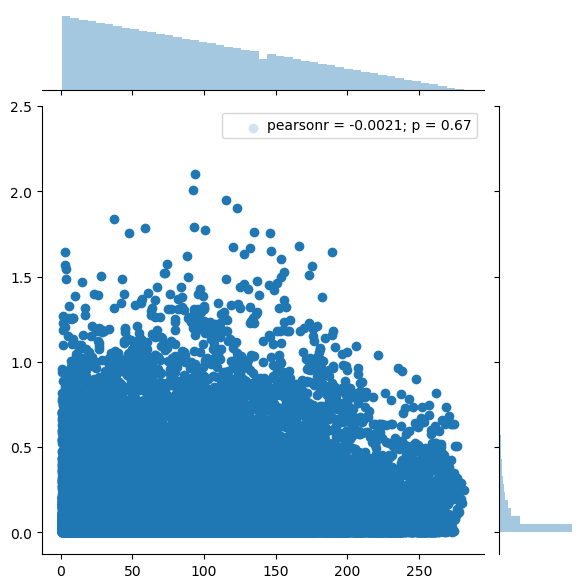

In [18]:


plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(huber))

plot.fig.set_dpi(100)



In [19]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [21]:
from skbio.stats.ordination import pcoa
from sklearn.metrics.pairwise import pairwise_distances
distance_matrix = pairwise_distances(huber, metric='precomputed')


You can use any distance metric you feel appropriate here if you change 'seuclidean'

In [26]:
from scipy.spatial.distance import pdist

n_coor = len(treefiles)
dist = np.zeros((n_coor, n_coor))
row,col = np.triu_indices(n_coor,1)
dist[row,col] = pdist(distance_matrix, metric='seuclidean')

In [309]:
output_mat = pd.DataFrame(dist)
output_mat.to_csv('gene_fam_matrix.tsv', sep=' ')

In [310]:
output_mat

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
0,0.0,1.635985e-24,5.847684,5.847684e+00,6.992466,8.419736,6.542187,11.245885,5.950090,8.089884,...,11.208851,32.459745,10.827650,10.332986,73.305763,12.814096,32.379255,39.603344,19.077412,27.950357
1,0.0,0.000000e+00,5.847684,5.847684e+00,6.992466,8.419736,6.542187,11.245885,5.950090,8.089884,...,11.208851,32.459745,10.827650,10.332986,73.305763,12.814096,32.379255,39.603344,19.077412,27.950357
2,0.0,0.000000e+00,0.000000,1.284228e-24,3.333780,5.018989,2.408399,9.384877,0.606392,4.523772,...,11.277304,34.885022,10.182825,10.041596,75.327944,13.371793,32.859801,41.571037,21.627902,30.393789
3,0.0,0.000000e+00,0.000000,0.000000e+00,3.333780,5.018989,2.408399,9.384877,0.606392,4.523772,...,11.277304,34.885022,10.182825,10.041596,75.327944,13.371793,32.859801,41.571037,21.627902,30.393789
4,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,3.745771,3.181081,8.754229,3.327396,4.530104,...,11.918027,35.292459,10.588733,10.408935,75.610320,13.464494,33.094732,41.946374,22.179193,30.857050
5,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,4.225188,6.850064,5.009906,4.085992,...,13.764072,34.975183,11.266132,11.431231,74.869157,13.913273,33.318503,41.754932,22.643936,30.760145
6,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.192379,2.467055,3.624743,...,12.070196,34.773824,10.359794,10.438431,74.938815,13.457429,32.984851,41.383159,21.856608,30.314101
7,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9.371709,7.999477,...,17.535290,33.067928,14.088205,14.602494,71.426675,15.057407,31.774783,39.031505,22.443854,29.099044
8,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,4.482462,...,11.266665,34.919529,10.186184,10.041514,75.356727,13.370572,32.860239,41.596742,21.651322,30.422693
9,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.783650,35.742553,11.244306,11.418035,75.075509,14.268797,32.474804,41.386025,22.931278,31.237437
